**Fitting a reward model offline**

In this example, we'll train a vanilla PPO agent on the Brax Ant environment using the "ground truth" reward provided by the environment. We'll then fit a reward model to the resulting clips.

In order to do this, we'll need to "record" a subset of the environment states visited by the agent during the training process. For this we can use the `BraxRecorder` environment wrapper class, which uses JAX host callbacks to efficiently record these states without interrupting Brax's wicked fast all-GPU training loop.

In [2]:
from brax.envs import create_fn
from brax.training import ppo
from classroom.brax import BraxRecorder
import numpy as np


def env_fn(name: str, db_path: str):
    brax_fn = create_fn(env_name=name)
    return lambda *args, **kwargs: BraxRecorder(brax_fn(*args, **kwargs), db_path)


inference, params, metrics = ppo.train(
    environment_fn=env_fn('ant', '~/classroom/ant'), num_timesteps = 30_000_000,
    log_frequency = 10, reward_scaling = .1, episode_length = 1000,
    normalize_observations = True, action_repeat = 1, unroll_length = 5,
    num_minibatches = 32, num_update_epochs = 4, discounting = 0.97,
    learning_rate = 3e-4, entropy_cost = 1e-2, num_envs = 2048,
    batch_size = 1024
)

/home/nora/miniconda3/lib/python3.10/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


(<function brax.training.ppo.make_inference_fn.<locals>.inference_fn(params, obs, key)>,
 ((DeviceArray(29491200., dtype=float32),
   DeviceArray([ 5.76340258e-01,  9.01916504e-01,  2.58659804e-03,
                -4.69714850e-02, -1.90610871e-01,  9.07656997e-02,
                 7.35080302e-01, -3.31008099e-02, -7.79484153e-01,
                 6.62133619e-02, -6.69017971e-01, -3.86176594e-02,
                 7.17971802e-01,  4.26348972e+00, -7.26184100e-02,
                 2.89751794e-02, -1.77051239e-02,  1.05141617e-01,
                -4.74078115e-03,  2.32848823e-02, -6.55472726e-02,
                 3.36886235e-02,  7.00239167e-02,  2.19721422e-02,
                 8.27182457e-02, -5.65480115e-03, -1.02745250e-01,
                 2.02341871e-05, -4.19983735e-06, -1.41219217e-02,
                 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                -2.98183281e-02, -1.10408422e-02, -1.39004156e-01,
                 0.00000000e+00,  0.00000000e+00,  0.00000000e+00

If you like, you can now use the Classroom GUI to input your own preferences on the resulting clips. For this example, though, we'll simulate the human preference feedback by stochastically generating preferences based on the ground truth rewards. `SyntheticPairwisePrefs` samples the preference for each pair of clips from a mixture distribution with two components:
- a distribution based on the [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model) of pairwise comparison, where the probability of preferring A to B is equal to the sigmoid of the difference in "scores" of A and B, and
- a uniform distribution over the two clips, representing the possibility of the human making a "mistake" and selecting a clip at random.

The "scores" for the Bradley-Terry distribution are the rescaled sums of rewards for each clip. `SyntheticPairwisePrefs` normalizes the rewards to zero mean and unit variance, then scales them by a "rationality" parameter β which defaults to 5.0. You can also choose the weight assigned to the mistake distribution with the `mistake_prob` parameter; by default it is set to 0.1.

Note that the total number of pairwise comparisons in any dataset scales quadratically with the dataset size, which could easily get unwieldy with even medium-size datasets. Training a model on all `N(N - 1) // 2` pairs of clips could also lead to overfitting since the model will see each clip many times per epoch. To prevent this, `SyntheticPairwisePrefs` samples a subset of `N` clip pairs _without replacement_ by shuffling the dataset and creating pairs from adjacent clips in the shuffled dataset. The random seed used to sample clip pairs and preferences can be set using the `seed` parameter and defaults to 0.

In [2]:
from classroom.brax import flatten_clip
from classroom.datasets import SyntheticPairwisePrefs, EnsembleDataset
import jax.numpy as jnp
import numpy as np


ds = SyntheticPairwisePrefs(
    '/home/nora/value-learning/ant',
    in_memory=True,
    transform=flatten_clip
)
ds = EnsembleDataset(ds, 5)

Loading rewards from /home/nora/value-learning/ant/seed_0/rewards.csv
Loading rewards from /home/nora/value-learning/ant/seed_1/rewards.csv
Loading rewards from /home/nora/value-learning/ant/seed_2/rewards.csv
Loading rewards from /home/nora/value-learning/ant/seed_3/rewards.csv
Loading rewards from /home/nora/value-learning/ant/seed_4/rewards.csv
Loading rewards from /home/nora/value-learning/ant/seed_5/rewards.csv
Loading rewards from /home/nora/value-learning/ant/seed_6/rewards.csv
Loading rewards from /home/nora/value-learning/ant/seed_7/rewards.csv
Loading rewards from /home/nora/value-learning/ant/seed_8/rewards.csv
Loading rewards from /home/nora/value-learning/ant/seed_9/rewards.csv


In [3]:
from classroom.datasets import BatchedDataset, SubsetDataset
import numpy as np

indices = np.random.permutation(len(ds))
test_size = round(len(ds) * 0.2)

test = SubsetDataset(ds, indices[:test_size])
# val = SubsetDataset(ds, indices[test_size:test_size * 2])
# train = SubsetDataset(ds, indices[test_size * 2:])
val = BatchedDataset(SubsetDataset(ds, indices[test_size:test_size * 2]), 64, dim=1)
train = BatchedDataset(SubsetDataset(ds, indices[test_size * 2:]), 64, dim=1)

We recommend implementing your preference model as a subclass of `classroom.jax.PairwisePrefModel` if possible, since this base class implements most of the training loop boilerplate code for you.

In [4]:
from classroom.jax import ListwisePrefModel, PairwisePrefModel
import flax.linen as nn
import jax.numpy as jnp


class MlpPrefModel(PairwisePrefModel):
    hidden_layers: list[int]

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for size in self.hidden_layers:
            x = nn.Dense(size)(x)
            x = nn.activation.relu(x)
            # x = nn.Dropout(0.1)(x, deterministic=eval)
        
        # scores, var = RandomFeatureGaussianProcess(1)(x)
        scores = nn.Dense(1)(x)
        return scores.squeeze(-1)

Training the model is as simple as calling `model.fit()` with your training and validation datasets.

In [5]:
model = MlpPrefModel([32, 16])
state = model.fit(train, val, seed=jnp.arange(5))

Epoch 1 train loss: 0.450, val acc: 0.866 (sd 0.001), val loss: 0.371 (sd 0.002)
Epoch 2 train loss: 0.367, val acc: 0.868 (sd 0.001), val loss: 0.367 (sd 0.001)
Epoch 3 train loss: 0.364, val acc: 0.869 (sd 0.000), val loss: 0.365 (sd 0.001)
Epoch 4 train loss: 0.363, val acc: 0.869 (sd 0.001), val loss: 0.364 (sd 0.001)
Epoch 5 train loss: 0.362, val acc: 0.869 (sd 0.001), val loss: 0.364 (sd 0.001)
Epoch 6 train loss: 0.361, val acc: 0.869 (sd 0.001), val loss: 0.363 (sd 0.001)
Epoch 7 train loss: 0.361, val acc: 0.869 (sd 0.001), val loss: 0.363 (sd 0.001)
Epoch 8 train loss: 0.360, val acc: 0.869 (sd 0.001), val loss: 0.363 (sd 0.001)
Epoch 9 train loss: 0.360, val acc: 0.869 (sd 0.001), val loss: 0.363 (sd 0.001)
Epoch 10 train loss: 0.359, val acc: 0.869 (sd 0.001), val loss: 0.362 (sd 0.001)
Epoch 11 train loss: 0.359, val acc: 0.869 (sd 0.001), val loss: 0.362 (sd 0.001)
Epoch 12 train loss: 0.359, val acc: 0.869 (sd 0.001), val loss: 0.362 (sd 0.001)
Epoch 13 train loss: 0.35

Now let's see if we can train an agent using the preference model we just created.

In [6]:
from brax.envs.env import Env, State, Wrapper
from classroom.jax import PrefModel
from dataclasses import dataclass
from jax.experimental.host_callback import id_tap
import flax.linen as nn
import jax.numpy as jnp
import jax

env_rewards = []
model_rewards = []

@dataclass
class PrefEnsemble:
    model: PrefModel
    variables: dict

    def __post_init__(self):
        self._predict_fn = jax.jit(
            jax.vmap(
                lambda variables, x: self.model.apply(variables, x),
                in_axes=(0, None)   # type: ignore
            )
        )

    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        return self._predict_fn(self.variables, x)

class BraxEvaluator(Wrapper):
    def __init__(self, env: Env, ensemble: PrefEnsemble):
        super().__init__(env)

        self.env = env
        # self.env_rewards = []
        self.ensemble = ensemble
    
    def step(self, state: State, action: jnp.ndarray) -> State:
        next_state = super().step(state, action)
        env_reward = next_state.reward.mean()
        id_tap(
            lambda rew, _: env_rewards.append(rew),
            env_reward
        )
        # return next_state

        transition = jnp.concatenate([state.obs, action], axis=-1)
        scores = self.ensemble(transition).min(axis=0).clip(-1)

        id_tap(
            lambda rew, _: model_rewards.append(rew),
            scores.mean()
        )
        return next_state.replace(reward=scores)  # type: ignore[attr-defined]

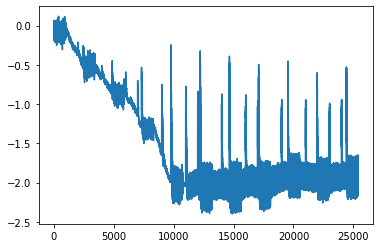

In [9]:
import matplotlib.pyplot as plt

plt.plot(
    np.arange(len(env_rewards)),
    env_rewards
)
# plt.plot(
#     np.arange(len(model_rewards)),
#     model_rewards,
#     c='red'
# )

In [7]:
from brax.envs import create_fn
from brax.training import ppo
import numpy as np

metric_history = []

def progress(_, metrics):
    metric_history.append(metrics)

def env_fn(name: str, ensemble: PrefEnsemble):
    brax_fn = create_fn(env_name=name)
    return lambda *args, **kwargs: BraxEvaluator(brax_fn(*args, **kwargs), ensemble)


ensemble = PrefEnsemble(model, {'params': state.params})
inference, params, metrics = ppo.train(
    environment_fn=env_fn('ant', ensemble),
    num_timesteps = 30_000_000,
    log_frequency = 10, reward_scaling = .1, episode_length = 1000,
    normalize_observations = True, action_repeat = 1, unroll_length = 5,
    num_minibatches = 32, num_update_epochs = 4, discounting = 0.97,
    learning_rate = 3e-4, entropy_cost = 1e-2, num_envs = 2048,
    batch_size = 1024, progress_fn = progress
)

/home/nora/miniconda3/lib/python3.10/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
